## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [49]:
df = pd.read_csv("../data/data.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [50]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [88]:
df['question1'].iloc[0]

'What is the step by step guide to invest in share market in india?'

In [89]:
df['question2'].iloc[0]

'What is the step by step guide to invest in share market?'

### Exploration

In [51]:
df['qid1'].nunique()

290654

In [52]:
df['qid1'].value_counts()

8461      50
14110     48
1749      47
20628     47
25984     47
          ..
223037     1
223039     1
223041     1
223043     1
537932     1
Name: qid1, Length: 290654, dtype: int64

In [53]:
df[df['qid1'] == 8461].head()

,id,qid1,qid2,question1,question2,is_duplicate
4279,4279,8461,8462,How do I improve my English speaking?,How do I improve my pronunciation in English?,1
11300,11300,8461,10859,How do I improve my English speaking?,How can I specifically improve my English?,1
14828,14828,8461,11396,How do I improve my English speaking?,How can I improve my English speaking ability?,1
23369,23369,8461,2438,How do I improve my English speaking?,How can I improve my pronunciation in English?,1
27111,27111,8461,12214,How do I improve my English speaking?,How can I improve my pronunciation of English ...,1


In [54]:
df['qid2'].nunique()

299364

In [55]:
df.shape

(404290, 6)

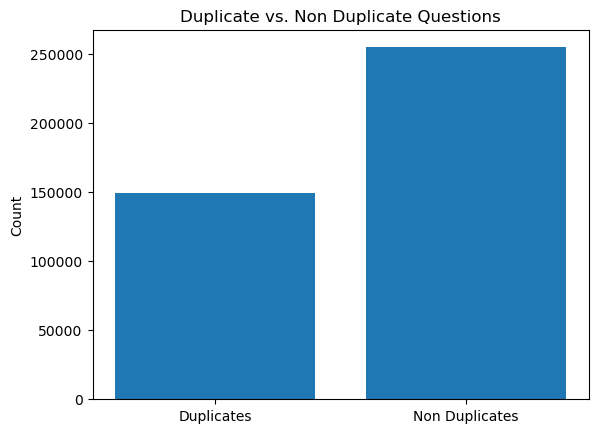

In [56]:
# graph the number of duplicate questions vs non dupes
non_dupe = df[df['is_duplicate'] == 0]
dupe = df[df['is_duplicate'] == 1]

plt.bar(x = ['Duplicates', 'Non Duplicates'], height = [dupe.shape[0], non_dupe.shape[0]])
plt.title('Duplicate vs. Non Duplicate Questions')
plt.ylabel('Count')
plt.show()

In [104]:
non_dupe.shape

(255027, 6)

In [105]:
dupe.shape

(149263, 6)

### There are ~100000 more non duplicate questions than duplicates in the data

In [57]:
dupe.shape[0]

149263

In [58]:
df[df.isna().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


##### drop the null values

In [59]:
df_null = df.dropna()

In [60]:
df_null.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [61]:
df_dupes = df_null[df_null['is_duplicate'] == 1]
df_non_dupes = df_null[df_null['is_duplicate'] == 0]

df_dupes = df_dupes.sample(100000, random_state= 123)
df_non_dupes = df_non_dupes.sample(100000, random_state= 123)

df_null = pd.concat([df_dupes, df_non_dupes])

In [62]:
df_null.shape

(200000, 6)

In [63]:
df_processed = df_null.copy()

In [64]:
df_processed.head()

,id,qid1,qid2,question1,question2,is_duplicate
216091,216091,42298,59575,What was the significance of the battle of Som...,What was the significance of the battle of Som...,1
309736,309736,433770,433771,What is the state of the art in natural langua...,What is the state-of-the-art of natural langua...,1
235371,235371,218549,29638,Is the iPhone really more expensive? Why or wh...,Why is iPhone so expensive?,1
76287,76287,41866,59185,How can I stop thinking about something?,How can i stop thinking about something/someone ?,1
83691,83691,141624,131268,Why is UK better than USA?,"Which country do you like the most, UK or USA?...",1


In [101]:
df_processed[df_processed['is_duplicate'] == 1]

,id,qid1,qid2,question1,question2,is_duplicate,question1_processed,question2_processed
216091,216091,42298,59575,What was the significance of the battle of Som...,What was the significance of the battle of Som...,1,"[signific, battl, somm, battl, compar, contras...","[signific, battl, somm, battl, compar, contras..."
309736,309736,433770,433771,What is the state of the art in natural langua...,What is the state-of-the-art of natural langua...,1,"[state, art, natur, languag, understand]","[stateoftheart, natur, languag, understand]"
235371,235371,218549,29638,Is the iPhone really more expensive? Why or wh...,Why is iPhone so expensive?,1,"[iphon, realli, expens]","[iphon, expens]"
76287,76287,41866,59185,How can I stop thinking about something?,How can i stop thinking about something/someone ?,1,"[stop, think, someth]","[stop, think, somethingsomeon, ]"
83691,83691,141624,131268,Why is UK better than USA?,"Which country do you like the most, UK or USA?...",1,"[uk, better, usa]","[countri, like, uk, usa]"
...,...,...,...,...,...,...,...,...
321323,321323,447010,447011,How can I make website designer and change his...,How can I make website designer and change his...,1,"[make, websit, design, chang, line, donig, ema...","[make, websit, design, chang, line, email, mar..."
257929,257929,373353,373354,Is it normal to get headaches when wearing new...,Is it normal to get headaches when you wear ne...,1,"[normal, get, headach, wear, new, glass, ]","[normal, get, headach, wear, new, glass]"
6395,6395,12532,12533,If you remove someone from the people you may ...,If I remove someone who I think keeps viewing ...,1,"[remov, someon, peopl, may, know, list, facebo...","[remov, someon, think, keep, view, facebook, p..."
234123,234123,344542,344543,Startups: Do you need to have product ready to...,Do you need to have the product ready to get V...,1,"[startup, need, product, readi, seek, fund, id...","[need, product, readi, get, vc, fund, enough, ..."


In [112]:
df_processed[df_processed['id'] == 287359].values

array([[287359, 408126, 408127,
        'What are some interesting facts about Pennsylvania?',
        "What are some interesting facts about Pennsylvania that many Pennsylvania locals don't even know about?",
        0, list(['interest', 'fact', 'pennsylvania']),
        list(['interest', 'fact', 'pennsylvania', 'mani', 'pennsylvania', 'local', 'dont', 'even', 'know'])]],
      dtype=object)

In [120]:
df_processed[df_processed['id'] == 235371]['question2_processed'].astype(str)

235371    ['iphon', 'expens']
Name: question2_processed, dtype: object

In [121]:
df_processed[df_processed['id'] == 363112]['question2_processed'].astype(str)

363112    ['could', 'gain', 'weight', 'quickli']
Name: question2_processed, dtype: object

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [65]:
# take from NLP data_prep exercise
from text_preprocess import *

In [66]:
df_processed['question1_processed'] = df_null['question1'].apply(lambda x: preprocess(x))
df_processed['question2_processed'] = df_null['question2'].apply(lambda x: preprocess(x))

In [106]:
preprocess(non_dupe['question1'].iloc[0])

['step', 'step', 'guid', 'invest', 'share', 'market', 'india']

In [107]:
preprocess(non_dupe['question2'].iloc[0])

['step', 'step', 'guid', 'invest', 'share', 'market']

In [67]:
df_processed.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_processed,question2_processed
216091,216091,42298,59575,What was the significance of the battle of Som...,What was the significance of the battle of Som...,1,"[signific, battl, somm, battl, compar, contras...","[signific, battl, somm, battl, compar, contras..."
309736,309736,433770,433771,What is the state of the art in natural langua...,What is the state-of-the-art of natural langua...,1,"[state, art, natur, languag, understand]","[stateoftheart, natur, languag, understand]"
235371,235371,218549,29638,Is the iPhone really more expensive? Why or wh...,Why is iPhone so expensive?,1,"[iphon, realli, expens]","[iphon, expens]"
76287,76287,41866,59185,How can I stop thinking about something?,How can i stop thinking about something/someone ?,1,"[stop, think, someth]","[stop, think, somethingsomeon, ]"
83691,83691,141624,131268,Why is UK better than USA?,"Which country do you like the most, UK or USA?...",1,"[uk, better, usa]","[countri, like, uk, usa]"


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [68]:
# import vectorizers for BagOfWords and TFIDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [69]:
y = df_processed['is_duplicate']
X = df_processed.drop('is_duplicate', axis = 1)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [71]:
# make corpus from training set
q1_train = X_train['question1_processed'].astype(str)
q2_train = X_train['question2_processed'].astype(str)
question_corpus = q1_train + q2_train

In [72]:
# vectorize the top 25000 words
vectorizer = CountVectorizer(max_features=25000)

# fit the vectorizer on the training set
vectorizer.fit(question_corpus)

# transform train set
count_q1_train = vectorizer.transform(q1_train)
count_q2_train = vectorizer.transform(q2_train)
count_X_train = count_q1_train + count_q2_train

# transform test set
count_q1_test = vectorizer.transform(X_test['question1_processed'].astype(str))
count_q2_test = vectorizer.transform(X_test['question2_processed'].astype(str))
count_X_test = count_q1_test + count_q2_test

In [73]:
# make csvs to move to docker environment
df_processed.to_csv("../data/processed.csv")

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

In [133]:
# logistic regression on CountVectorizer
count_log_clf = LogisticRegression(C=0.5, max_iter=1000)
count_log_clf.fit(count_X_train, y_train)

count_y_pred = count_log_clf.predict(count_X_test)
count_y_proba = count_log_clf.predict_proba(count_X_test)

In [127]:
count_y_proba

array([[0.46016599, 0.53983401],
       [0.2197614 , 0.7802386 ],
       [0.6567779 , 0.3432221 ],
       ...,
       [0.58196385, 0.41803615],
       [0.21118451, 0.78881549],
       [0.77168799, 0.22831201]])

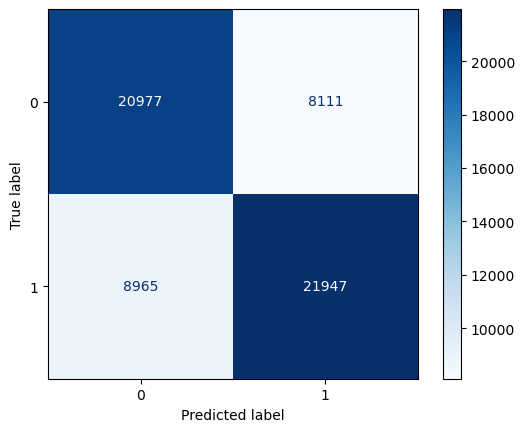

In [134]:
cm = confusion_matrix(count_y_pred, y_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [129]:
def get_metrics(pred, true):
    print(f'Accuracy Score: {accuracy_score(true,pred)}')
    print(f'Precision Score: {precision_score(true,pred)}')
    print(f'Recall Score: {recall_score(true,pred)}')

In [130]:
get_metrics(count_y_pred, y_test)
print(f'Log Loss: {log_loss(y_test,count_y_proba)}')

Accuracy Score: 0.7154
Precision Score: 0.7099831780538303
Recall Score: 0.7301550336017034
Log Loss: 0.5593986268134513


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.715


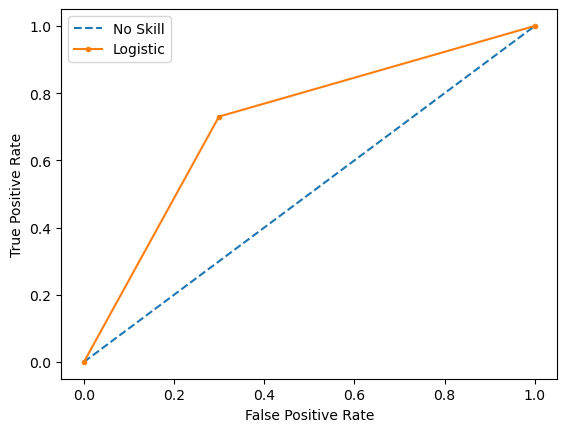

In [79]:
# generate a no skill prob
no_skill = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, no_skill)
lr_auc = roc_auc_score(y_test, count_y_pred)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, no_skill)
lr_fpr, lr_tpr, _ = roc_curve(y_test, count_y_pred)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [80]:
import xgboost as xgb

In [131]:
# xgb on Count Vectorizer
count_xgb = xgb.XGBClassifier(objective='binary:logistic', eval_metric = "logloss")
count_xgb.fit(count_X_train, y_train)

count_y_pred = count_xgb.predict(count_X_test)
count_y_proba = count_xgb.predict_proba(count_X_test)

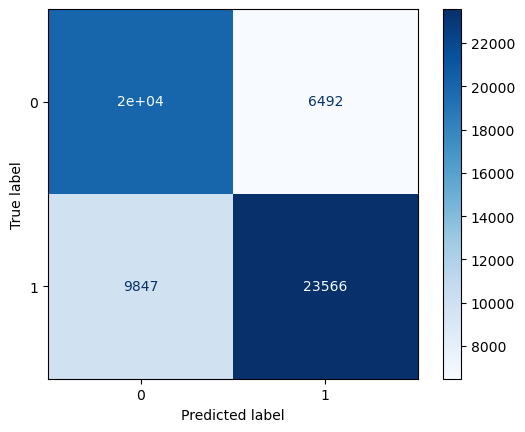

Accuracy Score: 0.7276833333333333
Precision Score: 0.7052943465118368
Recall Score: 0.7840175660389913
Log Loss: 0.5453490453411398


In [132]:
cm = confusion_matrix(count_y_pred, y_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()
get_metrics(count_y_pred, y_test)
print(f'Log Loss: {log_loss(y_test,count_y_proba)}')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.728


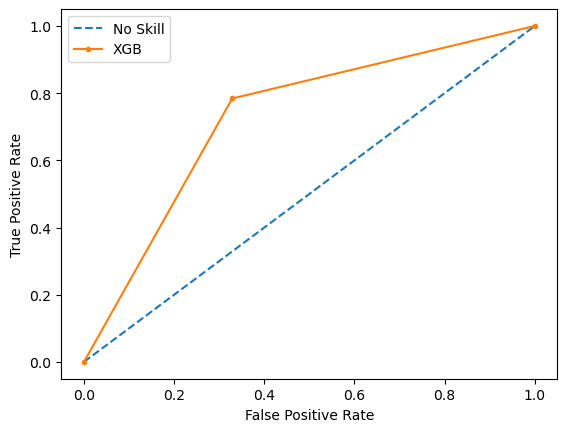

In [83]:
# calculate scores
ns_auc = roc_auc_score(y_test, no_skill)
lr_auc = roc_auc_score(y_test, count_y_pred)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, no_skill)
lr_fpr, lr_tpr, _ = roc_curve(y_test, count_y_pred)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGB')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [84]:
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}


In [85]:
from sklearn.model_selection import GridSearchCV


In [86]:
# grid search not finishing
# grid = GridSearchCV(count_xgb, params)

# grid.fit(count_X_train, y_train)